In [125]:
from scipy.spatial import Delaunay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib
import planar_manipulator
importlib.reload(planar_manipulator)
from planar_manipulator import PlanarManipulator

In [126]:
my_data = pd.read_csv('my_data.csv')
print(my_data.head())

points = np.vstack((my_data['x2'], my_data['y2'])).T
tri = Delaunay(points)

q1_lim = np.array([-np.pi, np.pi])
q2_lim = np.array([-np.pi, np.pi])

robot = PlanarManipulator(1.0, 1.0, q1_lim, q2_lim)

         q1        q2        x2        y2
0 -1.570796 -1.047198 -0.866025 -1.500000
1 -1.506682 -1.047198 -0.768141 -1.552405
2 -1.442568 -1.047198 -0.667100 -1.598430
3 -1.378454 -1.047198 -0.563317 -1.637887
4 -1.314340 -1.047198 -0.457220 -1.670614


In [127]:
def is_inside_workspace(point):
    return tri.find_simplex(point) >= 0


In [128]:
import tensorflow as tf
from keras.api.models import load_model

In [129]:
def mdn_loss_with_joint_penalty(y_true, y_pred):
    n_components = 2
    n_dims = 2

    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])
    norm = (y_true_exp - mu) / sigma
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))
    gauss = coeff * tf.exp(exponent)
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8
    mdn_loss = -tf.math.log(total_prob)

    # --- Add joint limit penalty ---
    q1_min, q1_max = -np.pi/2, np.pi/2
    q2_min, q2_max = -np.pi/3, np.pi/3

    q1 = mu[:, :, 0]
    q2 = mu[:, :, 1]

    q1_violation = tf.maximum(0.0, q1 - q1_max) + tf.maximum(0.0, q1_min - q1)
    q2_violation = tf.maximum(0.0, q2 - q2_max) + tf.maximum(0.0, q2_min - q2)

    joint_penalty = tf.reduce_sum(q1_violation + q2_violation, axis=1)

    return tf.reduce_mean(mdn_loss + 10.0 * joint_penalty)  # Adjust weight if needed


In [130]:
def mdn_loss(y_true, y_pred):
    n_components = 2
    n_dims = 2

    # Split model outputs and process outputs
    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])

    # Normalized difference
    norm = (y_true_exp - mu) / sigma

    # Exponent term
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)

    # Normalizing coefficient
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))

    # Gaussian component density
    gauss = coeff * tf.exp(exponent)

    
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8

    loss = -tf.math.log(total_prob)
    return tf.reduce_mean(loss)


In [ ]:
def decode_mdn_output(pred):
    n_components = 2
    n_dims = 2

    pi_logits = pred[:, :n_components]
    pi = tf.nn.softmax(pi_logits).numpy()

    mu = pred[:, n_components:n_components + n_components * n_dims]
    mu = mu.reshape(-1, n_components, n_dims)

    sigma = pred[:, n_components + n_components * n_dims:]
    sigma = np.exp(sigma).reshape(-1, n_components, n_dims)

    return pi, mu, sigma


path = 'models\my_mdn2_1_model_50_50_50.keras'
model = load_model(path, custom_objects={'mdn_loss': mdn_loss})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


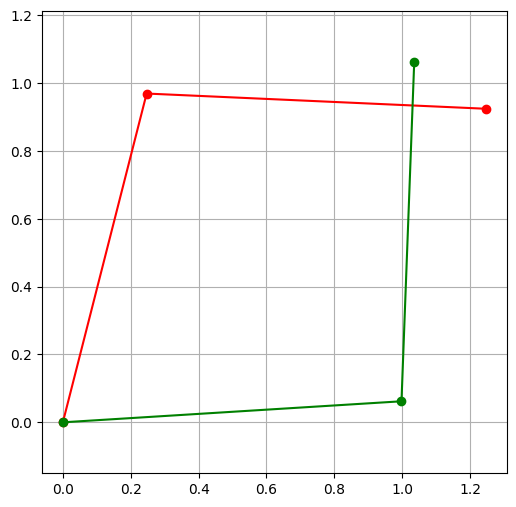

In [132]:
point = np.array([[0.9, 1.2]])
pred = model.predict(point)
pi, mu, sigma = decode_mdn_output(pred)

plt.figure(figsize=(6, 6))
robot.plot(mu[0,0,0], mu[0,0,1], color='red')
robot.plot(mu[0,1,0], mu[0,1,1], color='green')
plt.grid(True)

In [133]:
def define_elbow(q):
    elbow, wrist = robot.forward_kinematics(q)
    phi1 = np.arctan2((elbow[:,1]-0), (elbow[:,0]-0))
    phi2 = np.arctan2((wrist[:,1]-elbow[:,1]), (wrist[:,0]-elbow[:,0]))
    return 'up' if (phi1>phi2) > 0 else 'down'


test1 = define_elbow(np.array([[mu[0,0,0], mu[0,0,1]]]))
print(test1)
test2 = define_elbow(np.array([[mu[0,1,0], mu[0,1,1]]]))
print(test2)

up
down


In [134]:
from scipy.interpolate import make_interp_spline

In [135]:
waypoints = np.array([
    [0.5, -1.75],
    [0.7, -1.6],
    [0.9, -1.2],
    [1.0, -1.5]
])

deltas = np.diff(waypoints, axis=0)
distances = np.linalg.norm(deltas, axis=1)
t = np.concatenate([[0], np.cumsum(distances)])

x = waypoints[:, 0].reshape(-1,1)
y = waypoints[:, 1].reshape(-1,1)

x_spline = make_interp_spline(t, x)
y_spline = make_interp_spline(t, y)
t_fine = np.linspace(t[0], t[-1], 100)
x_path = x_spline(t_fine)
y_path = y_spline(t_fine)

All points are inside the workspace.


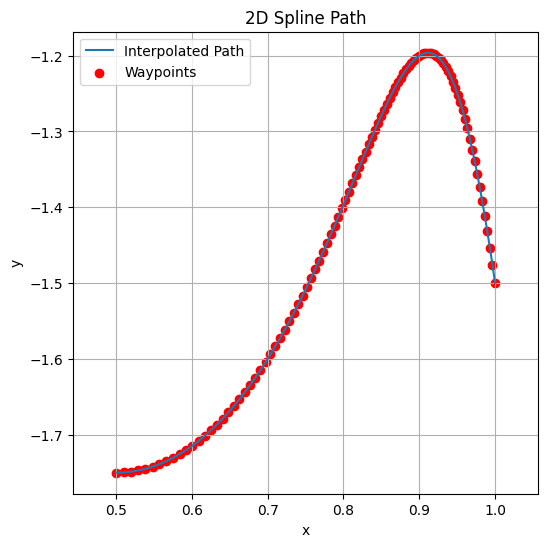

In [136]:
path = np.hstack((x_path, y_path))
result = is_inside_workspace(path)

if not np.all(result):
    print("At least one point is outside the workspace.")
else:
    print("All points are inside the workspace.")

plt.figure(figsize=(6,6))
plt.plot(path[:, 0], path[:, 1], label='Interpolated Path')
plt.scatter(path[:, 0], path[:, 1], color='red', label='Waypoints')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Spline Path')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Keeps scale correct for robot motion
plt.show()

In [137]:
def classify_elbow_mode(q_batch):
    elbow, wrist = robot.forward_kinematics(q_batch)
    phi1 = np.arctan2(elbow[:, 1], elbow[:, 0])
    phi2 = np.arctan2(wrist[:, 1] - elbow[:, 1], wrist[:, 0] - elbow[:, 0])
    return np.where(phi1 > phi2, 'up', 'down')


In [138]:
pred_path = model.predict(path)
pi_path, mu_path, sigma_path = decode_mdn_output(pred_path)

# Classify both predicted modes
mode0_type = classify_elbow_mode(mu_path[:, 0, :])
mode1_type = classify_elbow_mode(mu_path[:, 1, :])

# Preallocate
elbow_up = np.empty_like(mu_path[:, 0, :])
wrist_up = np.empty_like(mu_path[:, 0, :])
elbow_down = np.empty_like(mu_path[:, 0, :])
wrist_down = np.empty_like(mu_path[:, 0, :])

# Determine up/down per sample
for i in range(len(mu_path)):
    if mode0_type[i] == 'up':
        elbow_up[i], wrist_up[i] = robot.forward_kinematics(np.array([mu_path[i, 0, :]]))
        elbow_down[i], wrist_down[i] = robot.forward_kinematics(np.array([mu_path[i, 1, :]]))
    else:
        elbow_up[i], wrist_up[i] = robot.forward_kinematics(np.array([mu_path[i, 1, :]]))
        elbow_down[i], wrist_down[i] = robot.forward_kinematics(np.array([mu_path[i, 0, :]]))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [139]:
def inverse_kinematics_2link(x, y, L1=1.0, L2=1.0):
    D = (x**2 + y**2 - L1**2 - L2**2) / (2 * L1 * L2)
    if np.abs(D) > 1:
        return None  # unreachable

    q2_down = np.arctan2(np.sqrt(1 - D**2), D)
    q2_up = np.arctan2(-np.sqrt(1 - D**2), D)

    def q1(q2):  # helper
        k1 = L1 + L2 * np.cos(q2)
        k2 = L2 * np.sin(q2)
        return np.arctan2(y, x) - np.arctan2(k2, k1)

    return [(q1(q2_down), q2_down), (q1(q2_up), q2_up)]

true_elbow_down = []
true_wrist_down = []

true_elbow_up = []
true_wrist_up = []

for pt in path:
    sol = inverse_kinematics_2link(pt[0], pt[1])
    if sol is not None:
        (q1_down, q2_down), (q1_up, q2_up) = sol

        # Elbow-down
        el_d, wr_d = robot.forward_kinematics(np.array([[q1_down, q2_down]]))
        true_elbow_down.append([el_d[0, 0], el_d[0, 1]])
        true_wrist_down.append([wr_d[0, 0], wr_d[0, 1]])

        # Elbow-up
        el_u, wr_u = robot.forward_kinematics(np.array([[q1_up, q2_up]]))
        true_elbow_up.append([el_u[0, 0], el_u[0, 1]])
        true_wrist_up.append([wr_u[0, 0], wr_u[0, 1]])
    else:
        true_elbow_down.append([np.nan, np.nan])
        true_wrist_down.append([np.nan, np.nan])
        true_elbow_up.append([np.nan, np.nan])
        true_wrist_up.append([np.nan, np.nan])

true_elbow_down = np.array(true_elbow_down)
true_wrist_down = np.array(true_wrist_down)
true_elbow_up = np.array(true_elbow_up)
true_wrist_up = np.array(true_wrist_up)

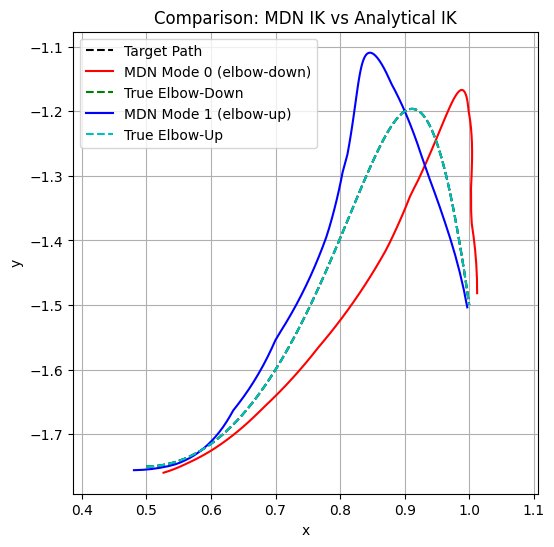

In [140]:
plt.figure(figsize=(6,6))
plt.plot(path[:,0], path[:,1], 'k--', label='Target Path')
plt.plot(wrist_down[:,0], wrist_down[:,1], 'r-', label='MDN Mode 0 (elbow-down)')
plt.plot(true_wrist_down[:,0], true_wrist_down[:,1], 'g--', label='True Elbow-Down')

plt.plot(wrist_up[:,0], wrist_up[:,1], 'b-', label='MDN Mode 1 (elbow-up)')
plt.plot(true_wrist_up[:,0], true_wrist_up[:,1], 'c--', label='True Elbow-Up')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title("Comparison: MDN IK vs Analytical IK")
plt.show()

In [141]:
all_points = np.vstack([
    wrist_up, elbow_up,
    wrist_down, elbow_down,
    true_wrist_down, true_elbow_down,
    true_wrist_up, true_elbow_up,
    path
])

# Compute bounds
x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])

# Add margin
margin = 0.2  # or any value you like
x_range = [x_min - margin, x_max + margin]
y_range = [y_min - margin, y_max + margin]

In [142]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import imageio_ffmpeg

print(animation.writers.list())

mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


In [143]:
video_elbow_up = 'ik_comparison_elbow_up.mp4'
if os.path.exists(video_elbow_up):
    print('video is existed')
else:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title("Elbow-Up: MDN vs Analytical IK")
    ax.plot(path[:, 0], path[:, 1], 'k--', label='Target Path')
    ax.legend()
    ax.grid(True)
    mdn_up_line, = ax.plot([], [], 'bo-', label='MDN Mode 1 (elbow-up)')
    true_up_line, = ax.plot([], [], 'co--', label='True Elbow-Up')

    def init_up():
        mdn_up_line.set_data([], [])
        true_up_line.set_data([], [])
        return mdn_up_line, true_up_line

    def animate_up(i):
        elbow1 = elbow_up[i]
        wrist1 = wrist_up[i]
        true_elbow_u = true_elbow_up[i]
        true_wrist_u = true_wrist_up[i]

        mdn_up_line.set_data([0, elbow1[0], wrist1[0]], [0, elbow1[1], wrist1[1]])
        true_up_line.set_data([0, true_elbow_u[0], true_wrist_u[0]], [0, true_elbow_u[1], true_wrist_u[1]])
        return mdn_up_line, true_up_line

    ani_up = animation.FuncAnimation(fig, animate_up, init_func=init_up, frames=len(path), interval=100, blit=True)
    ani_up.save("ik_comparison_elbow_up.mp4", writer='ffmpeg', fps=10, dpi=150)
    plt.close()

video is existed


In [144]:
video_elbow_down = 'ik_comparison_elbow_down.mp4'
if os.path.exists(video_elbow_down):
    print('video is existed')
else:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title("Elbow-Down: MDN vs Analytical IK")
    ax.plot(path[:, 0], path[:, 1], 'k--', label='Target Path')
    ax.legend()
    ax.grid(True)

    mdn_down_line, = ax.plot([], [], 'ro-', label='MDN Mode 0 (elbow-down)')
    true_down_line, = ax.plot([], [], 'go--', label='True Elbow-Down')

    def init_down():
        mdn_down_line.set_data([], [])
        true_down_line.set_data([], [])
        return mdn_down_line, true_down_line

    def animate_down(i):
        elbow0 = elbow_down[i]
        wrist0 = wrist_down[i]
        true_elbow_d = true_elbow_down[i]
        true_wrist_d = true_wrist_down[i]

        mdn_down_line.set_data([0, elbow0[0], wrist0[0]], [0, elbow0[1], wrist0[1]])
        true_down_line.set_data([0, true_elbow_d[0], true_wrist_d[0]], [0, true_elbow_d[1], true_wrist_d[1]])
        return mdn_down_line, true_down_line

    ani_down = animation.FuncAnimation(fig, animate_down, init_func=init_down, frames=len(path), interval=100, blit=True)
    ani_down.save("ik_comparison_elbow_down.mp4", writer='ffmpeg', fps=10, dpi=150)
    plt.close()


video is existed
